In [1]:
from __future__ import annotations
import numpy as np
from typing import *
import copy
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
class MetricCollector:
    def __init__(self):
        self.best_individual_cost_each_gen = []
        self.avg_cost_each_gen = []

        self.best_elite_individual_cost_each_gen = []
        self.avg_elite_cost_each_gen = []

        self.best_middle_individual_cost_each_gen = []
        self.avg_middle_cost_each_gen = []

        self.best_lower_individual_cost_each_gen = []
        self.avg_lower_cost_each_gen = []

    def collect_all(self, best_individual_fitness: float, avg_fitness: float):
        self.best_individual_cost_each_gen.append(best_individual_fitness)
        self.avg_cost_each_gen.append(avg_fitness)

    def collect_elite(self, best_individual_fitness: float, avg_fitness: float):
        self.best_elite_individual_cost_each_gen.append(best_individual_fitness)
        self.avg_elite_cost_each_gen.append(avg_fitness)

    def collect_middle(self, best_individual_fitness: float, avg_fitness: float):
        self.best_middle_individual_cost_each_gen.append(best_individual_fitness)
        self.avg_middle_cost_each_gen.append(avg_fitness)

    def collect_lower(self, best_individual_fitness: float, avg_fitness: float):
        self.best_lower_individual_cost_each_gen.append(best_individual_fitness)
        self.avg_lower_cost_each_gen.append(avg_fitness)

    def compile_graphs(self):
        # make subplot for 4 graphs
        fig, axs = plt.subplots(2, 2)
        fig.suptitle('DE Metrics')
        # plot best individual cost
        axs[0, 0].plot(self.best_individual_cost_each_gen, label="Best Individual")
        axs[0, 0].plot(self.avg_cost_each_gen, label="Average")
        axs[0, 0].set_title("All")
        axs[0, 0].legend()
        # plot best elite individual cost
        axs[0, 1].plot(self.best_elite_individual_cost_each_gen, label="Best Individual")
        axs[0, 1].plot(self.avg_elite_cost_each_gen, label="Average")
        axs[0, 1].set_title("Elite")
        axs[0, 1].legend()
        # plot best middle individual cost
        axs[1, 0].plot(self.best_middle_individual_cost_each_gen, label="Best Individual")
        axs[1, 0].plot(self.avg_middle_cost_each_gen, label="Average")
        axs[1, 0].set_title("Middle")
        axs[1, 0].legend()
        # plot best lower individual cost
        axs[1, 1].plot(self.best_lower_individual_cost_each_gen, label="Best Individual")
        axs[1, 1].plot(self.avg_lower_cost_each_gen, label="Average")
        axs[1, 1].set_title("Lower")
        axs[1, 1].legend()
        # show the plot
        # increase plot size
        fig.set_size_inches(18.5, 10.5)
        plt.show()

In [3]:
def bound_applier(
    x: np.ndarray,
    bounds: List[Tuple]
):
    bounded = np.zeros_like(x)
    for i in range(len(x)):
        bounded[i] = x[i] * (bounds[i][1] - bounds[i][0]) + bounds[i][0]
    return bounded

def latin_hyper_cube_initializer(dimension: int, population_size: int, bounds: List[Tuple], seed: int = 0) -> np.ndarray:
    lsh_sampler = stats.qmc.LatinHypercube(d=dimension, seed=seed)
    sample = lsh_sampler.random(n=population_size)
    bounded = np.apply_along_axis(
        lambda x: bound_applier(x, bounds),
        1,
        sample
    )
    return bounded

In [4]:
def rand_1_2_pop_bin_mutator(
    population1: np.ndarray,
    population2: np.ndarray,
    differential_factor: float,
    f: Callable
):
    x1, x2 = np.random.choice(population1.shape[0], 2, replace=False)
    x3 = np.random.choice(population2.shape[0])
    target_vector = population1[x1]
    mutant_vector = target_vector + differential_factor * (population1[x2] - population2[x3])
    return target_vector, mutant_vector

def rand_2_3_pop_bin_mutator(
    population1: np.ndarray,
    population2: np.ndarray,
    population3: np.ndarray,
    differential_factor: float,
    f: Callable
):
    x1 = np.random.choice(population1.shape[0])
    x2, x3 = np.random.choice(population2.shape[0], 2, replace=False)
    x4, x5 = np.random.choice(population3.shape[0], 2, replace=False)
    target_vector = population1[x1]
    mutant_vector = target_vector + differential_factor * (population2[x2] - population2[x3] + population3[x4] - population3[x5])
    return target_vector, mutant_vector

def binomial_crossover(
    target_vector: np.ndarray,
    mutant_vector: np.ndarray,
    crossover_prob: float
):
    crossover = np.zeros_like(target_vector)
    for i in range(len(target_vector)):
        if np.random.rand() < crossover_prob:
            crossover[i] = mutant_vector[i]
        else:
            crossover[i] = target_vector[i]
    return crossover

In [238]:
def two_way_merge_sorted_array(
    population1: np.ndarray,
    population1_val: np.ndarray,
    population2: np.ndarray,
    population2_val: np.ndarray,
    merge_size: int,
):
    merged = np.zeros((merge_size, population1.shape[1]))
    merged_val = np.zeros(merge_size)
    i = 0
    j = 0
    k = 0
    while i < population1.shape[0] and j < population2.shape[0] and k < merge_size:
        if population1_val[i] < population2_val[j]:
            merged[k] = population1[i]
            merged_val[k] = population1_val[i]
            i += 1
        else:
            merged[k] = population2[j]
            merged_val[k] = population2_val[j]
            j += 1
        k += 1
    return merged, merged_val, population1[i:], population2[j:], population1_val[i:], population2_val[j:], i, j

def three_way_merge_sorted_array(
    population1: np.ndarray,
    population1_val: np.ndarray,
    population2: np.ndarray,
    population2_val: np.ndarray,
    population3: np.ndarray,
    population3_val: np.ndarray,
    merge_size: int,
):
    merged = np.zeros((merge_size, population1.shape[1]))
    merged_val = np.zeros(merge_size)
    i = 0
    j = 0
    k = 0
    l = 0
    while i < population1.shape[0] and j < population2.shape[0] and k < population3.shape[0] and l < merge_size:
        min_of_three = np.argmin([population1_val[i], population2_val[j], population3_val[k]])
        if min_of_three == 0:
            merged[l] = population1[i]
            merged_val[l] = population1_val[i]
            i += 1
        elif min_of_three == 1:
            merged[l] = population2[j]
            merged_val[l] = population2_val[j]
            j += 1
        else:
            merged[l] = population3[k]
            merged_val[l] = population3_val[k]
            k += 1
        l += 1
    return merged, merged_val, population1[i:], population2[j:], population3[k:], population1_val[i:], population2_val[j:], population3_val[k:], i, j, k

def ttp_de(
    f: Callable,
    pop_initializer: Callable[[int], np.ndarray],
    elite_pop_size: int,
    middle_pop_size: int,
    lower_pop_size: int,
    differential_factor: float,
    T: float,
    alpha: float,
    crossover_prob: float,
    crossover_func: Callable[[np.ndarray, np.ndarray, float], np.ndarray],
    n_iter: int,
    metric: MetricCollector = MetricCollector()
):
    elite_pop = pop_initializer(elite_pop_size)
    middle_pop = pop_initializer(middle_pop_size)
    lower_pop = pop_initializer(lower_pop_size)

    for i in range(n_iter):
        if i % 10 == 0:
            T *= alpha
            print(f"Iteration {i}: {f(elite_pop[0])} {T} {alpha}")
        elitist_offspring = []
        middle_offspring = []
        lower_offspring = []

        for j in range(elite_pop_size):
            target_vector, mutant_vector = rand_1_2_pop_bin_mutator(elite_pop, elite_pop, differential_factor, f)
            crossover = crossover_func(target_vector, mutant_vector, crossover_prob)
            elitist_offspring.append(crossover)

        for j in range(middle_pop_size//4):
            target_vector, mutant_vector = rand_1_2_pop_bin_mutator(elite_pop, middle_pop, differential_factor, f)
            crossover = crossover_func(target_vector, mutant_vector, crossover_prob)
            middle_offspring.append(crossover)

        for j in range(middle_pop_size//4):
            target_vector, mutant_vector = rand_1_2_pop_bin_mutator(middle_pop, middle_pop, differential_factor, f)
            crossover = crossover_func(target_vector, mutant_vector, crossover_prob)
            middle_offspring.append(crossover)

        for j in range(middle_pop_size//4):
            target_vector, mutant_vector = rand_1_2_pop_bin_mutator(middle_pop, lower_pop, differential_factor, f)
            crossover = crossover_func(target_vector, mutant_vector, crossover_prob)
            middle_offspring.append(crossover)

        for j in range(middle_pop_size//4):
            target_vector, mutant_vector = rand_2_3_pop_bin_mutator(elite_pop, middle_pop, lower_pop, differential_factor, f)
            crossover = crossover_func(target_vector, mutant_vector, crossover_prob)
            middle_offspring.append(crossover)

        for j in range(lower_pop_size//4):
            target_vector, mutant_vector = rand_1_2_pop_bin_mutator(elite_pop, lower_pop, differential_factor, f)
            crossover = crossover_func(target_vector, mutant_vector, crossover_prob)
            lower_offspring.append(crossover)

        for j in range(lower_pop_size//4):
            target_vector, mutant_vector = rand_1_2_pop_bin_mutator(lower_pop, lower_pop, differential_factor, f)
            crossover = crossover_func(target_vector, mutant_vector, crossover_prob)
            lower_offspring.append(crossover)

        elite_pop_all = np.concatenate((elite_pop, np.array(elitist_offspring)), dtype=np.float64)
        elite_pop_val = np.apply_along_axis(f, 1, elite_pop_all)
        elite_pop_sorted_ind = np.argsort(elite_pop_val)

        middle_pop_all = np.concatenate((middle_pop, np.array(middle_offspring)), dtype=np.float64)
        middle_pop_val = np.apply_along_axis(f, 1, middle_pop_all)
        middle_pop_sorted_ind = np.argsort(middle_pop_val)

        lower_pop_all = np.concatenate((lower_pop, np.array(lower_offspring)), dtype=np.float64)
        lower_pop_val = np.apply_along_axis(f, 1, lower_pop_all)
        lower_pop_sorted_ind = np.argsort(lower_pop_val)

        elite_merged, elite_merged_val, elite_leftover, middle_leftover, lower_leftover, elite_leftover_val, middle_leftover_val, lower_leftover_val, elite_i, middle_j, lower_k = three_way_merge_sorted_array(
            elite_pop_all[elite_pop_sorted_ind[:elite_pop_size]],
            elite_pop_val[elite_pop_sorted_ind[:elite_pop_size]],
            middle_pop_all[middle_pop_sorted_ind[:middle_pop_size]],
            middle_pop_val[middle_pop_sorted_ind[:middle_pop_size]],
            lower_pop_all[lower_pop_sorted_ind[:lower_pop_size]],
            lower_pop_val[lower_pop_sorted_ind[:lower_pop_size]],
            elite_pop_size
        )

        middle = elite_leftover
        num_left_middle = middle_pop_size - middle.shape[0]
        leftover_sorted_ind = np.concatenate((middle_pop_sorted_ind[middle_j:], (middle_pop_sorted_ind.shape[0] - middle_j) + lower_pop_sorted_ind[lower_k:]))
        leftover_shuffled_ind = np.random.permutation(leftover_sorted_ind.shape[0])
        leftover_val = np.concatenate((middle_pop_val[middle_pop_sorted_ind[middle_j:]], lower_pop_val[lower_pop_sorted_ind[lower_k:]]))
        leftover_pop = np.concatenate((middle_pop_all[middle_pop_sorted_ind[middle_j:]], lower_pop_all[lower_pop_sorted_ind[lower_k:]]))
        middle_leftover_select = []
        middle_leftover_select_val = []
        lower_leftover_select = []
        lower_leftover_select_val = []

        for j in range(num_left_middle):
            delta = leftover_val[leftover_shuffled_ind[j]] - middle_pop_val[j + middle_j]
            if np.random.rand() < np.exp(-delta / T):
                middle_leftover_select.append(leftover_pop[leftover_shuffled_ind[j]])
                middle_leftover_select_val.append(leftover_val[leftover_shuffled_ind[j]])
            else:
                middle_leftover_select.append(middle_pop[j + middle_j])
                middle_leftover_select_val.append(middle_pop_val[j + middle_j])

        for j in range(lower_pop_size // 2):
            delta = lower_pop_val[j] - leftover_val[leftover_shuffled_ind[j + num_left_middle]]
            if np.random.rand() < np.exp(-delta / (T/differential_factor)):
                lower_leftover_select.append(lower_pop[j])
                lower_leftover_select_val.append(lower_pop_val[j])
            else:
                lower_leftover_select.append(leftover_pop[leftover_shuffled_ind[j + num_left_middle]])
                lower_leftover_select_val.append(leftover_val[leftover_shuffled_ind[j + num_left_middle]])


        for j in range(lower_pop_size // 4):
            rand_j = np.random.choice(elite_pop_all.shape[0])
            perturbed = elite_pop_all[rand_j] + np.random.normal(0, 1, elite_pop_all.shape[1])
            lower_leftover_select.append(perturbed)
            lower_leftover_select_val.append(f(perturbed))

        elite_pop = elite_merged
        middle_pop = np.concatenate((middle, np.array(middle_leftover_select)))
        lower_pop = np.concatenate((np.array(lower_leftover_select), pop_initializer((lower_pop_size - len(lower_leftover_select) // 2))))

        elite_pop_val = elite_merged_val
        middle_pop_val = np.concatenate((elite_leftover_val, np.array(middle_leftover_select_val)))
        lower_pop_val = np.array(lower_leftover_select_val)
        all_val = np.concatenate((elite_pop_val, middle_pop_val, lower_pop_val))

        metric.collect_all(f(elite_pop[0]), np.mean(all_val))
        metric.collect_elite(f(elite_pop[0]), np.mean(elite_pop_val))
        metric.collect_middle(f(elite_pop[0]), np.mean(middle_pop_val))
        metric.collect_lower(f(elite_pop[0]), np.mean(lower_pop_val))


    best_index = np.argmin(np.apply_along_axis(f, 1, elite_pop))
    best = elite_pop[best_index]
    best_val = f(best)
    return best, best_val

Iteration 0: 19.750933035888373 50.0 0.5
Iteration 10: 0.009807539926065544 25.0 0.5
Iteration 20: 0.0001440788189095807 12.5 0.5
Iteration 30: 1.4577464171436854e-07 6.25 0.5
Iteration 40: 7.390430306544522e-11 3.125 0.5
Iteration 50: 9.226420744719602e-12 1.5625 0.5
Iteration 60: 3.0284694634892156e-14 0.78125 0.5
Iteration 70: 1.2948794020682573e-16 0.390625 0.5
Iteration 80: 2.4339758907414737e-19 0.1953125 0.5
Iteration 90: 2.092670788594876e-21 0.09765625 0.5


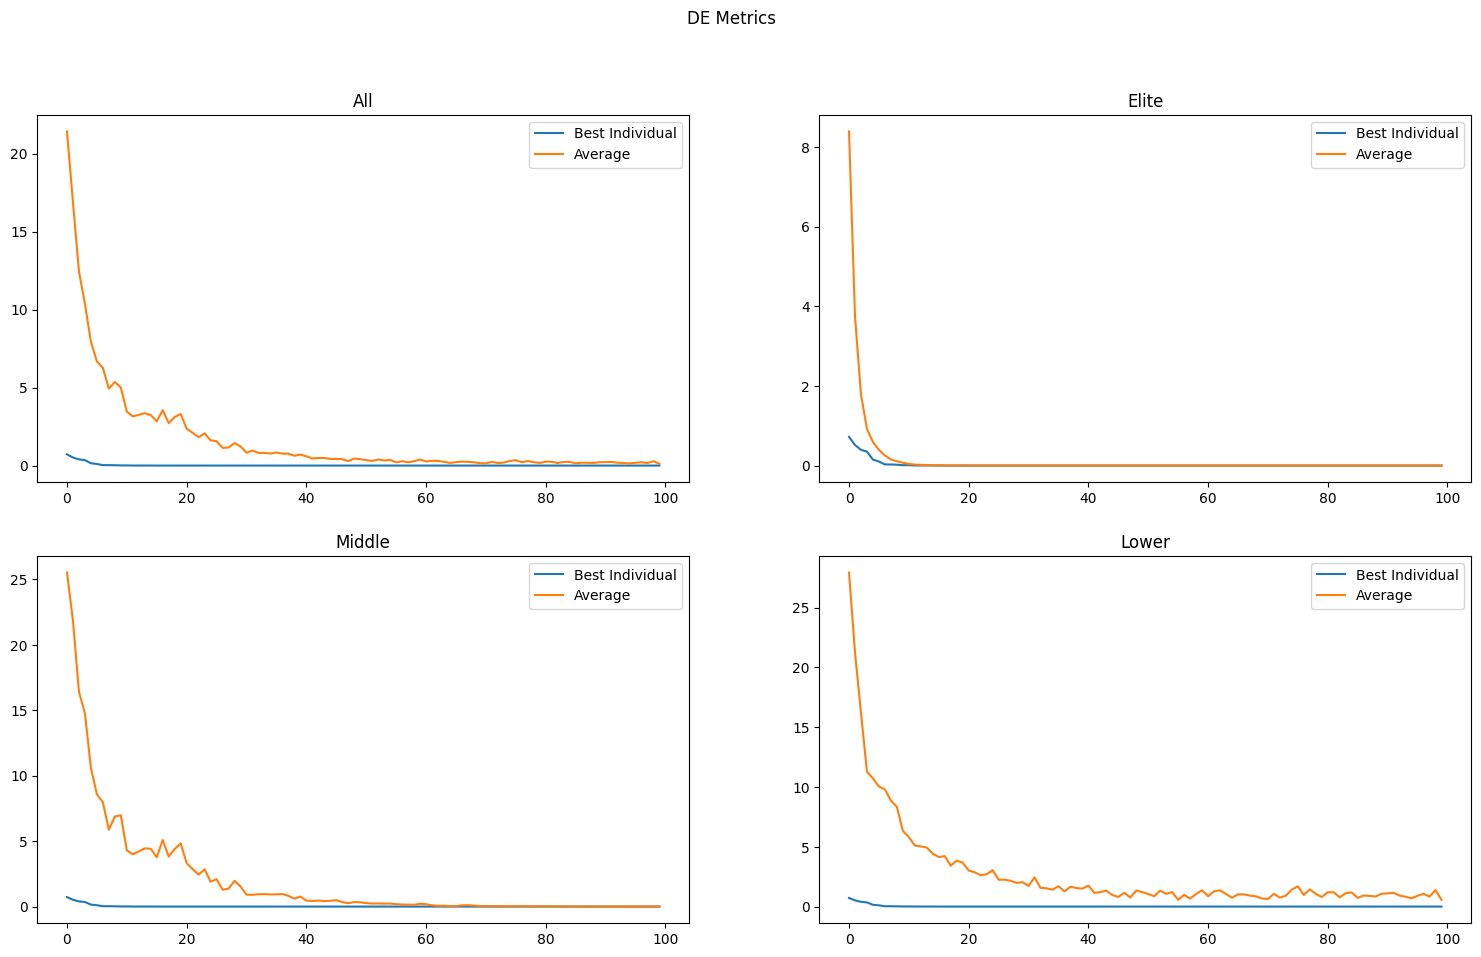

(array([-5.17751890e-13, -3.64936734e-13,  1.24799444e-12]),
 1.9587359677316957e-24)

In [239]:
def func_1(x: np.ndarray):
    return x[0] ** 2 + x[1] ** 2 + x[2] ** 2

def latin(d: int, bounds):
    return lambda x: latin_hyper_cube_initializer(d, x, bounds, 0)

metric_1 = MetricCollector()
elite_pop_size = 50
middle_pop_size = 100
lower_pop_size = 50
bounds = [(-5.12, 5.12) for _ in range(3)]
n_iters = 100

res = ttp_de(
    f=func_1,
    elite_pop_size=elite_pop_size,
    middle_pop_size=middle_pop_size,
    lower_pop_size=lower_pop_size,
    pop_initializer=latin(3, bounds),
    differential_factor=0.5,
    crossover_prob=0.5,
    crossover_func=binomial_crossover,
    n_iter=n_iters,
    metric=metric_1,
    T=100,
    alpha=0.5
)
metric_1.compile_graphs()
res

Iteration 0: 509981.34203254536 50.0 0.5


/var/folders/10/f1x_0l7x7hj_gbpjxb5_cpkc0000gn/T/ipykernel_41449/72330251.py:153: RuntimeWarning: overflow encountered in exp
  if np.random.rand() < np.exp(-delta / T):
/var/folders/10/f1x_0l7x7hj_gbpjxb5_cpkc0000gn/T/ipykernel_41449/72330251.py:162: RuntimeWarning: overflow encountered in exp
  if np.random.rand() < np.exp(-delta / (T/differential_factor)):


Iteration 10: 49838.96791699808 25.0 0.5
Iteration 20: 25354.568267875045 12.5 0.5
Iteration 30: 9561.934521717105 6.25 0.5
Iteration 40: 3318.333127511665 3.125 0.5
Iteration 50: 1368.7070414886045 1.5625 0.5
Iteration 60: 434.90127049034294 0.78125 0.5
Iteration 70: 178.6919127115434 0.390625 0.5
Iteration 80: 98.69892310289546 0.1953125 0.5
Iteration 90: 41.37334478531258 0.09765625 0.5
Iteration 100: 18.255785501368337 0.048828125 0.5
Iteration 110: 6.728217527668119 0.0244140625 0.5
Iteration 120: 3.6467758169396194 0.01220703125 0.5
Iteration 130: 1.3110292388476714 0.006103515625 0.5
Iteration 140: 0.6692565962316845 0.0030517578125 0.5
Iteration 150: 0.3205065725733905 0.00152587890625 0.5
Iteration 160: 0.19612554105688607 0.000762939453125 0.5
Iteration 170: 0.0908962612646071 0.0003814697265625 0.5
Iteration 180: 0.04472352267181806 0.00019073486328125 0.5
Iteration 190: 0.01564021904408813 9.5367431640625e-05 0.5


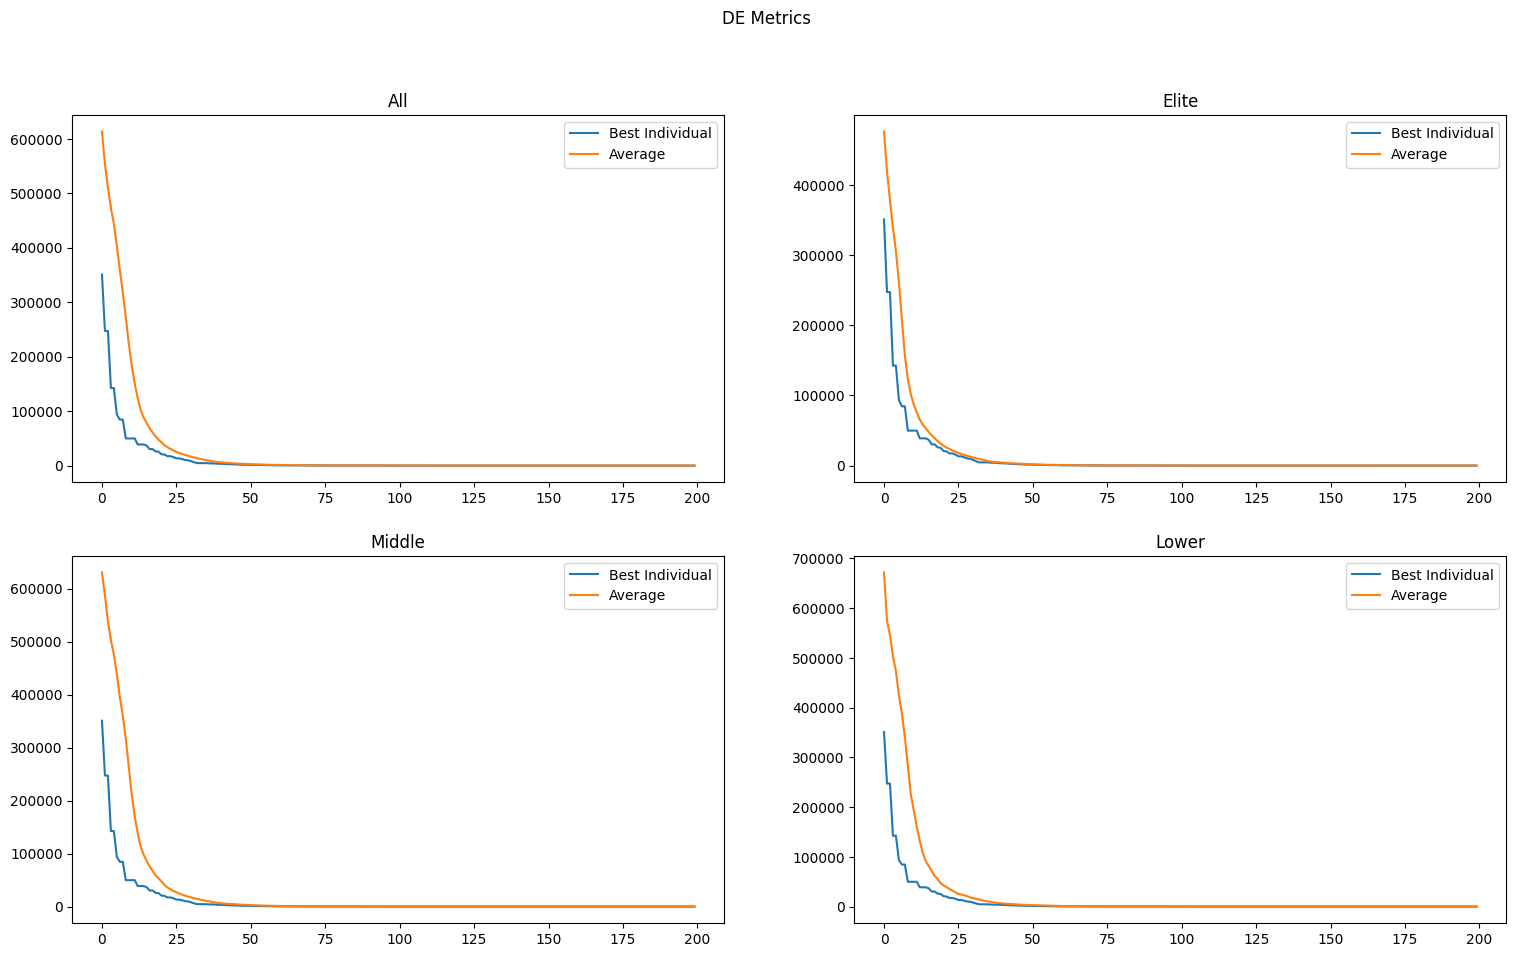

(array([ 3.07932304e-03, -1.00323463e-04, -1.06439269e-03, -6.25785333e-04,
        -2.14183375e-03, -2.71830880e-03, -1.04741166e-02, -5.52368550e-04,
        -6.45002186e-04, -5.28405728e-03, -4.09042846e-04,  5.83170480e-03,
        -4.79564406e-03, -3.65670674e-03,  2.81867674e-03,  5.50760060e-04,
         3.21188952e-03, -5.88913768e-03, -4.21136298e-05,  4.31357254e-03,
        -5.85129867e-03, -1.31490284e-03, -8.22255865e-04, -1.87290797e-04,
        -5.14823838e-04, -2.55334421e-04,  1.43048953e-03,  2.17669064e-03,
        -1.75890191e-02,  4.46540167e-03]),
 0.007115595262426501)

In [240]:
def func_5(x: np.ndarray):
    cost = 0
    for i in range(30):
        for j in range(i + 1):
            cost += x[j] ** 2
    return cost

metric_5 = MetricCollector()
bounds = [(-65.536, 65.536) for _ in range(30)]
d = 30
elite_pop_size = 50
middle_pop_size = 150
lower_pop_size = 100
n_iters = 200
res = ttp_de(
    f=func_5,
    elite_pop_size=elite_pop_size,
    middle_pop_size=middle_pop_size,
    lower_pop_size=lower_pop_size,
    pop_initializer=latin(d, bounds),
    differential_factor=0.5,
    crossover_prob=0.7,
    crossover_func=binomial_crossover,
    n_iter=n_iters,
    metric=metric_5,
    T=100,
    alpha=0.5
)
metric_5.compile_graphs()
res

Iteration 0: 3608.027533404759 50.0 0.5
Iteration 10: 82.43080638142897 25.0 0.5
Iteration 20: 19.734206931187746 12.5 0.5
Iteration 30: 12.451629852525386 6.25 0.5
Iteration 40: 9.771590715932737 3.125 0.5
Iteration 50: 8.225712711366713 1.5625 0.5
Iteration 60: 7.473816305399582 0.78125 0.5
Iteration 70: 6.943175823117958 0.390625 0.5
Iteration 80: 6.298098886917998 0.1953125 0.5
Iteration 90: 5.666500538857181 0.09765625 0.5
Iteration 100: 4.929494824028717 0.048828125 0.5
Iteration 110: 4.310245524903582 0.0244140625 0.5
Iteration 120: 3.71252162602181 0.01220703125 0.5
Iteration 130: 3.2714324416844285 0.006103515625 0.5
Iteration 140: 2.6694376336012198 0.0030517578125 0.5
Iteration 150: 1.9130322230252785 0.00152587890625 0.5
Iteration 160: 1.4917269888082318 0.000762939453125 0.5


/var/folders/10/f1x_0l7x7hj_gbpjxb5_cpkc0000gn/T/ipykernel_41449/1184290347.py:153: RuntimeWarning: overflow encountered in exp
  if np.random.rand() < np.exp(-delta / T):


Iteration 170: 1.1619806858196977 0.0003814697265625 0.5
Iteration 180: 0.6937193943259894 0.00019073486328125 0.5
Iteration 190: 0.4859472160250934 9.5367431640625e-05 0.5
Iteration 200: 0.3172063826202891 4.76837158203125e-05 0.5
Iteration 210: 0.18380898519091898 2.384185791015625e-05 0.5


/var/folders/10/f1x_0l7x7hj_gbpjxb5_cpkc0000gn/T/ipykernel_41449/1184290347.py:162: RuntimeWarning: overflow encountered in exp
  if np.random.rand() < np.exp(-delta / (T * 10)):


Iteration 220: 0.0870694444706142 1.1920928955078125e-05 0.5
Iteration 230: 0.058065991538718734 5.9604644775390625e-06 0.5
Iteration 240: 0.024717975591028233 2.9802322387695312e-06 0.5
Iteration 250: 0.010555416134910775 1.4901161193847656e-06 0.5
Iteration 260: 0.0071762270684379474 7.450580596923828e-07 0.5
Iteration 270: 0.0026548037578946766 3.725290298461914e-07 0.5
Iteration 280: 0.0016821582639603855 1.862645149230957e-07 0.5
Iteration 290: 0.0008498176224220976 9.313225746154785e-08 0.5
Iteration 300: 0.0003724194571301969 4.6566128730773926e-08 0.5
Iteration 310: 0.00019036395383424984 2.3283064365386963e-08 0.5
Iteration 320: 8.062141107705075e-05 1.1641532182693481e-08 0.5
Iteration 330: 3.97027656456806e-05 5.820766091346741e-09 0.5
Iteration 340: 1.3197059942116808e-05 2.9103830456733704e-09 0.5
Iteration 350: 8.605910120254397e-06 1.4551915228366852e-09 0.5
Iteration 360: 4.514337659476267e-06 7.275957614183426e-10 0.5
Iteration 370: 2.1851176743443545e-06 3.63797880709

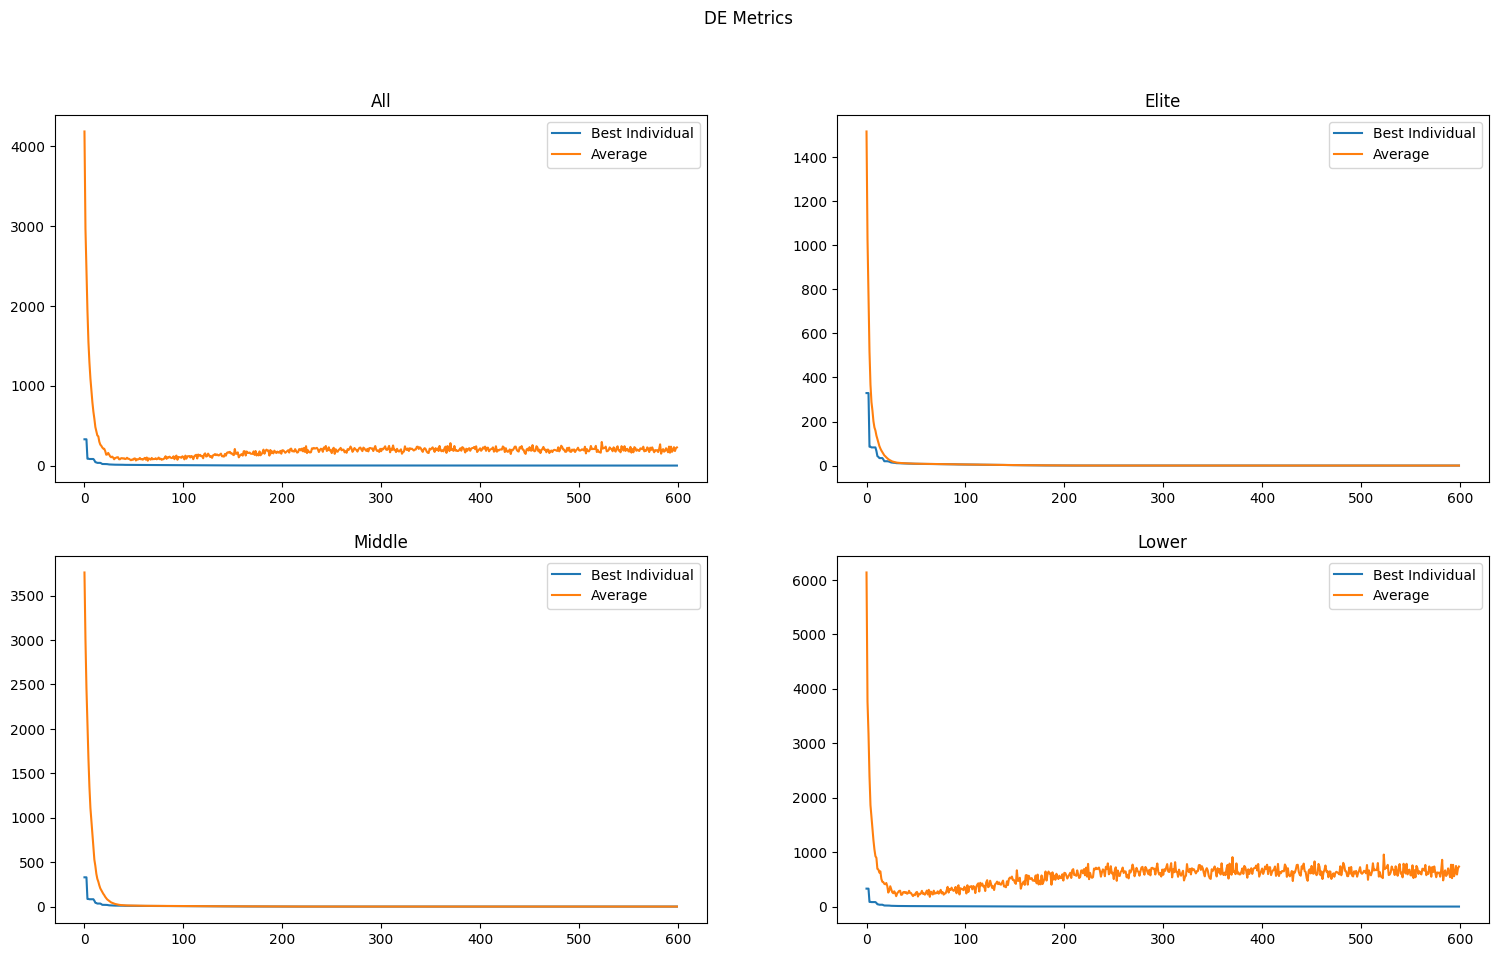

(array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.00000001, 1.00000001, 1.00000003, 1.00000005, 1.0000001 ]),
 8.454368514474789e-15)

In [221]:
def func_6(x: np.ndarray):
    cost = 0
    for i in range(9):
        cost += 100 * (x[i+1] - x[i]**2)**2 + (1 - x[i])**2
    return cost

metric_6 = MetricCollector()
bounds = [(-2.048, 2.048) for _ in range(10)]
d = 10
n_iters = 600
elite_pop_size = 50
middle_pop_size = 200
lower_pop_size = 150
res = ttp_de(
    f=func_6,
    elite_pop_size=elite_pop_size,
    middle_pop_size=middle_pop_size,
    lower_pop_size=lower_pop_size,
    pop_initializer=latin(d, bounds),
    differential_factor=0.6,
    crossover_prob=0.7,
    crossover_func=binomial_crossover,
    n_iter=n_iters,
    metric=metric_6,
    T=100,
    alpha=0.5
)
metric_6.compile_graphs()
res

Iteration 0: 2937.308732816855 5.0 0.5
Iteration 10: 1335.5445144216274 2.5 0.5


/var/folders/10/f1x_0l7x7hj_gbpjxb5_cpkc0000gn/T/ipykernel_41449/327449755.py:162: RuntimeWarning: overflow encountered in exp
  if np.random.rand() < np.exp(-delta / T):


Iteration 20: 709.1245944365154 1.25 0.5
Iteration 30: 503.2523791774653 0.625 0.5
Iteration 40: 378.7412015594941 0.3125 0.5
Iteration 50: 281.21800337991107 0.15625 0.5
Iteration 60: 203.19797484011676 0.078125 0.5


/var/folders/10/f1x_0l7x7hj_gbpjxb5_cpkc0000gn/T/ipykernel_41449/327449755.py:153: RuntimeWarning: overflow encountered in exp
  if np.random.rand() < np.exp(-delta / T):


Iteration 70: 160.70790922561272 0.0390625 0.5
Iteration 80: 123.80146891447001 0.01953125 0.5
Iteration 90: 104.86258220503174 0.009765625 0.5
Iteration 100: 87.380758139819 0.0048828125 0.5
Iteration 110: 73.3057968058259 0.00244140625 0.5
Iteration 120: 61.4606768778591 0.001220703125 0.5
Iteration 130: 51.816440521252275 0.0006103515625 0.5
Iteration 140: 42.957135546417156 0.00030517578125 0.5
Iteration 150: 38.12903280753881 0.000152587890625 0.5
Iteration 160: 33.15424696583993 7.62939453125e-05 0.5
Iteration 170: 27.17300928841647 3.814697265625e-05 0.5
Iteration 180: 22.6981690432278 1.9073486328125e-05 0.5
Iteration 190: 19.222556057299983 9.5367431640625e-06 0.5
Iteration 200: 16.608062527046915 4.76837158203125e-06 0.5
Iteration 210: 13.783734238048355 2.384185791015625e-06 0.5
Iteration 220: 12.083156901690534 1.1920928955078125e-06 0.5
Iteration 230: 10.61118908864343 5.960464477539062e-07 0.5
Iteration 240: 9.249880937743805 2.980232238769531e-07 0.5
Iteration 250: 8.129

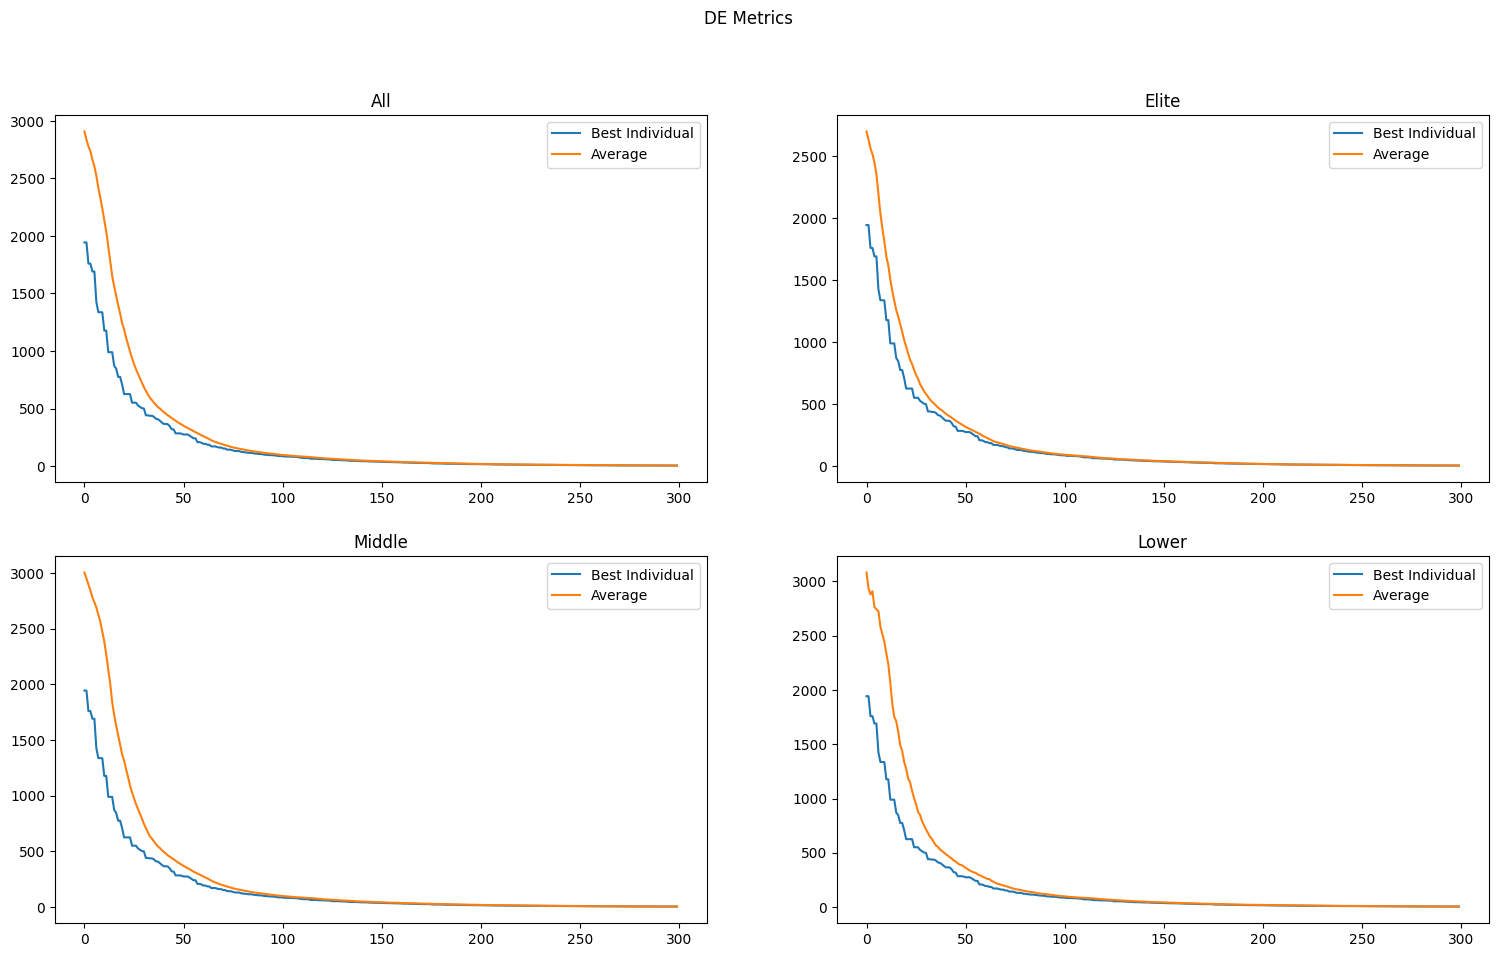

(array([  9.54768147,  24.15329358,  -7.63900988,  -4.12857582,
         -0.67722885,  -5.73247224, -12.2425357 ,   7.40440323,
          6.45170767, -12.67055443, -11.98483824,   1.38788088,
          3.60497391,   0.09164821,   2.63393495,   1.219137  ,
         36.44130366,  -8.3944104 ,   2.68705032,  -2.85605306,
          0.61123192,  -5.10660957, -15.10879049,  -0.44333475,
         -3.37037917,   0.28856298,  65.10337246,  -5.62853832,
        -10.2369078 ,  10.36295773,  11.91802259,  -1.38707276,
         -0.68287256,   3.04820914, -12.361701  , -26.02902002,
          9.98459723, -10.80595696,   8.23028269,   4.82119354,
          0.13276582,  -4.88768633,  -7.34144295,   0.49631798,
         -6.32150962,   4.23436256,  10.19442992,  -6.28329494,
         13.09560151,  -2.06296913,  -5.58560238,  12.61637233,
          4.29962921,  -1.35679778,  -2.82875618,   0.50234404,
         -9.16551729,  -7.90290406,   7.5752892 ,   9.77139747,
          5.06708806,   2.15060573,  -2.

In [233]:
def func_8(x: np.ndarray):
    cost = 1/4000 * np.sum(np.apply_along_axis(lambda y: y**2, 0, x))
    prod = 1
    for i in range(x.shape[0]):
        prod *= np.cos(x[i] / np.sqrt(i + 1))
    return cost - prod + 1

metric_8 = MetricCollector()
d = 100
bounds = [(-600, 600) for _ in range(d)]
elite_pop_size = 100
middle_pop_size = 150
lower_pop_size = 50
n_iters=300
res = ttp_de(
    f=func_8,
    elite_pop_size=elite_pop_size,
    middle_pop_size=middle_pop_size,
    lower_pop_size=lower_pop_size,
    pop_initializer=latin(d, bounds),
    differential_factor=0.5,
    crossover_prob=0.5,
    crossover_func=binomial_crossover,
    n_iter=n_iters,
    metric=metric_8,
    T=10,
    alpha=0.5
)
metric_8.compile_graphs()
res

Iteration 0: 2.676481253803446 50.0 0.5


/var/folders/10/f1x_0l7x7hj_gbpjxb5_cpkc0000gn/T/ipykernel_41449/327449755.py:162: RuntimeWarning: overflow encountered in exp
  if np.random.rand() < np.exp(-delta / T):


Iteration 10: 0.08816875411994816 25.0 0.5
Iteration 20: 0.016541832021332484 12.5 0.5
Iteration 30: 0.0034216314866967693 6.25 0.5
Iteration 40: 0.0010348934025205374 3.125 0.5
Iteration 50: 0.0002622332363519501 1.5625 0.5
Iteration 60: 0.00011033156332318306 0.78125 0.5
Iteration 70: 2.634235659405089e-05 0.390625 0.5
Iteration 80: 7.032719290733129e-06 0.1953125 0.5
Iteration 90: 2.2000114135708794e-06 0.09765625 0.5
Iteration 100: 2.8578907981257466e-07 0.048828125 0.5
Iteration 110: 1.1424358323768353e-07 0.0244140625 0.5
Iteration 120: 3.3972209733589e-08 0.01220703125 0.5
Iteration 130: 1.5645040962686156e-08 0.006103515625 0.5
Iteration 140: 5.547261534223304e-09 0.0030517578125 0.5
Iteration 150: 2.1118583856521e-09 0.00152587890625 0.5
Iteration 160: 9.210994845881506e-10 0.000762939453125 0.5
Iteration 170: 4.67433058539485e-10 0.0003814697265625 0.5
Iteration 180: 3.0277823492670876e-10 0.00019073486328125 0.5
Iteration 190: 1.8319759991513115e-10 9.5367431640625e-05 0.5


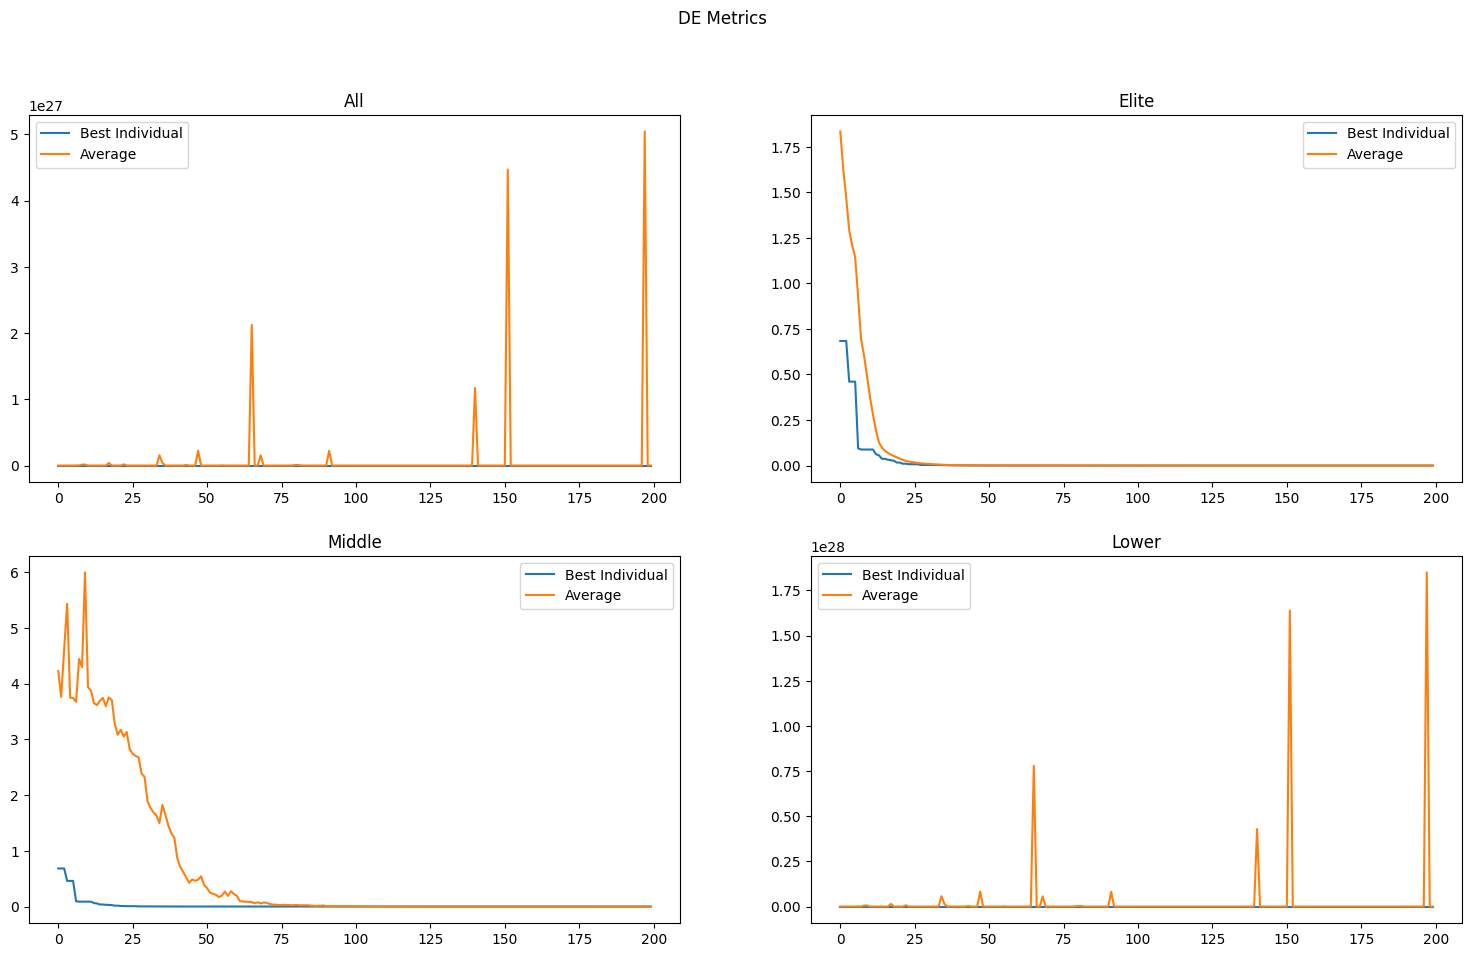

(array([-1.04753319e-12, -3.55039013e-06,  4.95197690e-05, -5.43352477e-04,
        -5.53246767e-03,  1.09273144e-02, -1.37184559e-02, -4.50043143e-02,
         4.14041351e-02,  7.34354390e-02, -9.60688495e-02, -8.71806987e-02,
         4.70913839e-02, -1.63189546e-01,  1.74632095e-01,  1.88708545e-01,
        -2.37063039e-01, -2.24100153e-01, -2.47540790e-01, -2.31556730e-01,
        -2.88461565e-01, -3.20383701e-01,  2.98877767e-01,  2.89017072e-01,
         1.38615563e-01,  3.13727454e-01, -3.22240684e-01,  1.91479587e-01,
         4.24680273e-01,  4.01167074e-01, -1.98655890e-01, -2.24902566e-01,
        -4.53342458e-01, -4.02446619e-01,  2.72933963e-01,  2.43113187e-01,
        -4.15313024e-01,  4.18867205e-01,  4.93955072e-01, -9.48665451e-02,
         1.98516939e-01, -2.66968900e-01,  4.24626121e-01, -4.87825817e-01,
         3.99491921e-01, -1.07901255e-01,  4.82454833e-01, -5.24000104e-01,
         3.87421288e-01,  1.83318120e-01]),
 1.3688869706062755e-10)

In [234]:
def func_9(x: np.ndarray):
    cost = 0
    for i in range(x.shape[0]):
        cost += np.abs(x[i]) ** (i + 1)
    return cost

metric_9 = MetricCollector()
d = 50
bounds = [(-1, 1) for _ in range(d)]
n_iters = 200
elite_pop_size = 50
middle_pop_size = 150
lower_pop_size = 100
F1 = 0.5
F2 = 0.5
F3 = 0.5
res = ttp_de(
    f=func_9,
    elite_pop_size=elite_pop_size,
    middle_pop_size=middle_pop_size,
    lower_pop_size=lower_pop_size,
    pop_initializer=latin(d, bounds),
    differential_factor=0.5,
    crossover_prob=0.5,
    crossover_func=binomial_crossover,
    n_iter=n_iters,
    metric=metric_9,
    T=100,
    alpha=0.5
)
metric_9.compile_graphs()
res

Iteration 0: 0.05815049807694658 80.0 0.8
Iteration 10: -3.8999217361897913 64.0 0.8
Iteration 20: -5.961950883221452 51.2 0.8
Iteration 30: -7.361722839545197 40.96000000000001 0.8
Iteration 40: -7.961190184188673 32.76800000000001 0.8
Iteration 50: -8.47878165085612 26.21440000000001 0.8
Iteration 60: -8.659727613043177 20.97152000000001 0.8
Iteration 70: -8.976772607927007 16.777216000000006 0.8
Iteration 80: -9.033548486203417 13.421772800000006 0.8
Iteration 90: -9.224349670817299 10.737418240000006 0.8
Iteration 100: -9.2802609091996 8.589934592000004 0.8
Iteration 110: -9.431682760606098 6.871947673600004 0.8
Iteration 120: -9.449941972270164 5.497558138880003 0.8
Iteration 130: -9.471714319144171 4.398046511104003 0.8
Iteration 140: -9.589135030914484 3.5184372088832023 0.8
Iteration 150: -9.593858329737404 2.814749767106562 0.8
Iteration 160: -9.596777917437057 2.25179981368525 0.8
Iteration 170: -9.596862320641613 1.8014398509482001 0.8
Iteration 180: -9.596877684854233 1.441

/var/folders/10/f1x_0l7x7hj_gbpjxb5_cpkc0000gn/T/ipykernel_41449/327449755.py:162: RuntimeWarning: overflow encountered in exp
  if np.random.rand() < np.exp(-delta / T):


Iteration 390: -9.659981979911242 0.013292279957849186 0.8
Iteration 400: -9.660041167805597 0.010633823966279349 0.8
Iteration 410: -9.660705413218098 0.00850705917302348 0.8
Iteration 420: -9.660848090028274 0.006805647338418784 0.8
Iteration 430: -9.660848115963041 0.005444517870735028 0.8
Iteration 440: -9.66084811629272 0.004355614296588022 0.8
Iteration 450: -9.660848116310202 0.003484491437270418 0.8
Iteration 460: -9.660848116312064 0.0027875931498163344 0.8
Iteration 470: -9.66084811631239 0.0022300745198530676 0.8
Iteration 480: -9.660848116312426 0.0017840596158824541 0.8
Iteration 490: -9.660848116312431 0.0014272476927059633 0.8


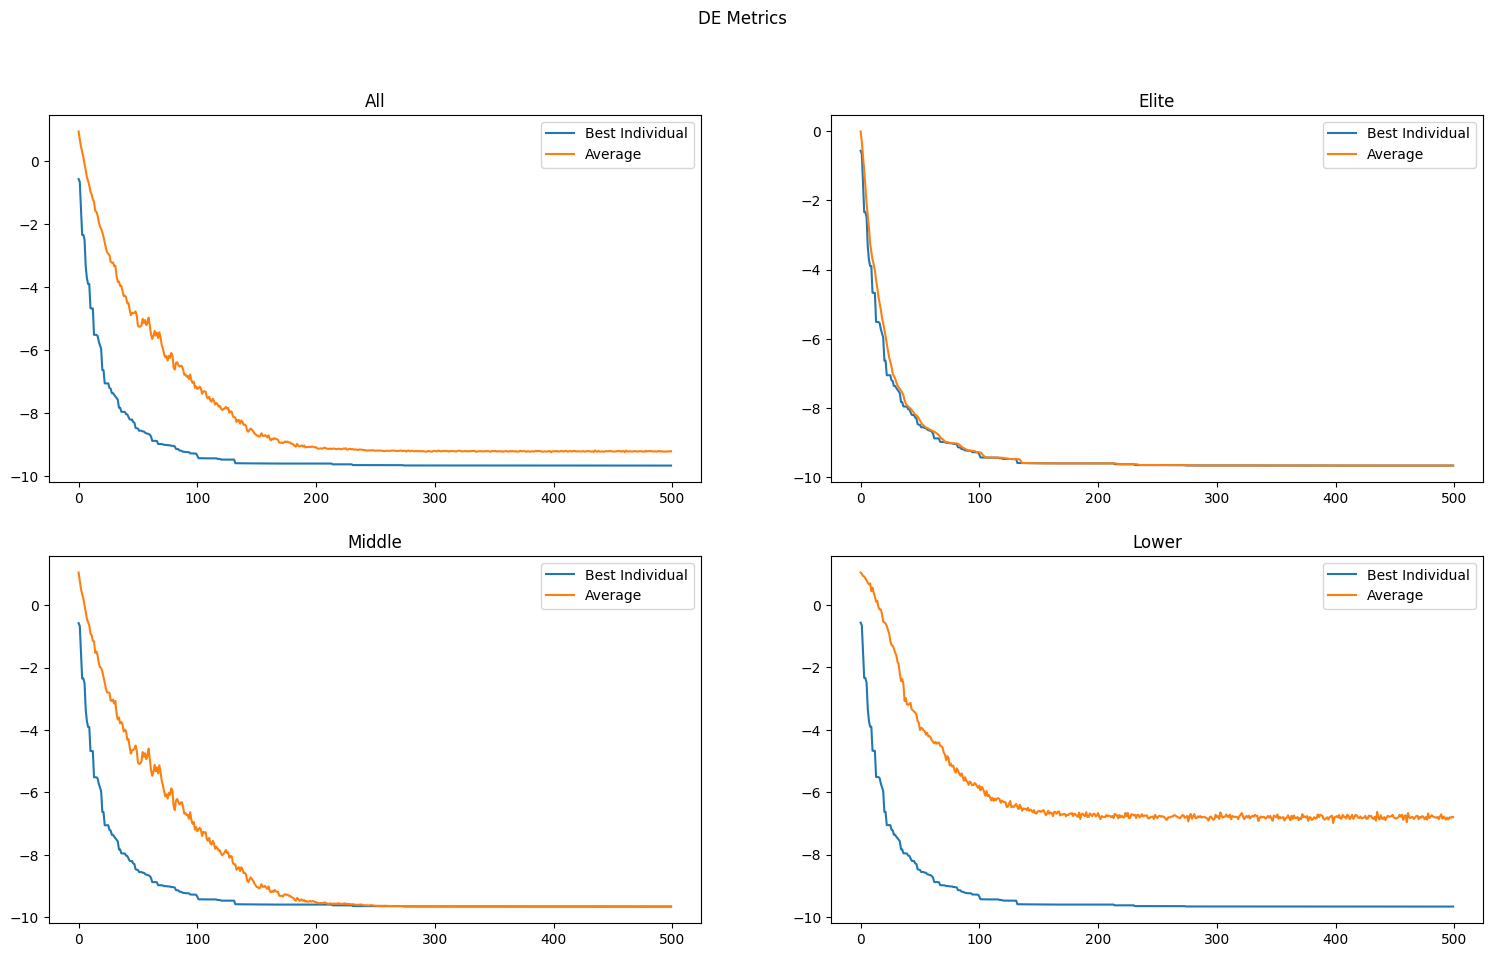

(array([-2.20290552,  4.71238898, -1.28499157, -1.92305847, -1.72046977,
        -1.57079633, -1.45441397,  4.77738502,  4.74138661,  4.81482156]),
 -9.660848116312433)

In [237]:
def func_10(x: np.ndarray):
    cost = 0
    for i in range(x.shape[0]):
        cost += np.sin(x[i]) * (np.sin((i + 1) * x[i]**2 / np.pi)) ** (2 * 10)
    return cost

metric_10 = MetricCollector()
d = 10
bounds = [(0, np.pi) for _ in range(d)]
elite_pop_size = 50
middle_pop_size = 350
lower_pop_size = 100
n_iters=500
res = ttp_de(
    f=func_10,
    elite_pop_size=elite_pop_size,
    middle_pop_size=middle_pop_size,
    lower_pop_size=lower_pop_size,
    pop_initializer=latin(d, bounds),
    differential_factor=0.5,
    crossover_prob=0.3,
    crossover_func=binomial_crossover,
    n_iter=n_iters,
    metric=metric_10,
    T=100,
    alpha=0.8
)
metric_10.compile_graphs()
res

In [96]:
def func_13(x: np.ndarray):
    cost = 0
    for i in range(x.shape[0]):
        for k in range(21):
            cost += 0.5**k * np.cos(2 * np.pi * 3**k * (x[i] + 0.5))
    return cost

metric_13 = MetricCollector()
d = 50
bounds = [(-10, 10) for _ in range(d)]
elite_pop_size = 50
middle_pop_size = 100
lower_pop_size = 50
n_iters=200
res = ttp_de(
    f=func_13,
    elite_pop_size=elite_pop_size,
    middle_pop_size=middle_pop_size,
    lower_pop_size=lower_pop_size,
    pop_initializer=latin(d, bounds),
    differential_factor=0.5,
    crossover_prob=0.5,
    crossover_func=binomial_crossover,
    n_iter=n_iters,
    metric=metric_13,
    T=10,
    alpha=0.7
)
metric_13.compile_graphs()
res

Iteration 0: -3.503930236702439 7.0 0.7
Iteration 10: -22.085204155316873 4.8999999999999995 0.7


KeyboardInterrupt: 